In [1]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
from pydy.system import System
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# init_printing(False)
init_printing(True)
import itable
import pandas as pd
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

//anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# Constants
Length1 = 0.5
Length2 = 0.5
point1_mass = 8
point2_mass = 8
cart_mass = 10

In [3]:
# Create the Main Frame
A = me.ReferenceFrame('A')

# Create the symbols
x, y, beta, theta, f = me.dynamicsymbols('x y beta theta f')
x_dot, y_dot, f_cart = me.dynamicsymbols('x_dot y_dot f_cart')
beta_dot, theta_dot = me.dynamicsymbols('beta_dot theta_dot')

M, m1, m2, g, t = sympy.symbols('M m1 m2 g t')
L1, L2 = sympy.symbols('L1 L2')

# Orient the other frames
B = A.orientnew('B', 'Axis', [beta, A.z])
C = A.orientnew('C', 'Axis', [theta, A.z])

In [4]:
# Create the Origin
Origin = me.Point('Origin')
Origin.set_pos(Origin, 0)
Origin.set_vel(A, 0)

# Create the Rod Points
P0 = me.Point('P0')
P1 = me.Point('P1')
P2 = me.Point('P2')

# Set the Rod End Points Positions
P0.set_pos(Origin, x * A.x + y * A.y)
P1.set_pos(P0, -L1 * B.y)
P2.set_pos(P1, -L2 * C.y)

In [5]:
# Set the Velocities of the Points
P0.set_vel(A, x_dot * A.x + y_dot * A.y)
P1.v2pt_theory(P0, A, B)
P2.v2pt_theory(P1, A, C)

In [6]:
# Set up the kinematic differential equations
kde = [x_dot - x.diff(t),
       y_dot - y.diff(t),
       beta_dot - beta.diff(t),
       theta_dot - theta.diff(t)]

# Create the Particles
Pa0 = me.Particle('Pa0', P0, M)
Pa1 = me.Particle('Pa1', P1, m1)
Pa2 = me.Particle('Pa2', P2, m2)

In [8]:
# Creating the forces acting on the bodies
grav_force_0 = (P0, -M * g * A.y)
grav_force_1 = (P1, -m1 * g * A.y)
grav_force_2 = (P2, -m2 * g * A.y)
static_force = (P0, (m1 + m2 + M) * g * A.y)

rot_force = (B, f * A.z)
cart_force = (P0, f_cart * A.x)

pen1_k = (B, -beta * 1 * A.z)
pen2_k = (C, -theta * 1 * A.z)

pen1_d = (B, -beta_dot * 0.1 * A.z)
pen2_d = (C, -theta_dot * 0.1 * A.z)

# horizontal = (P0, -y * 1000000 * A.y)

loads = [grav_force_0,
         grav_force_1,
         grav_force_2,
         static_force,
         rot_force,
         cart_force,
         horizontal,
         pen1_k,
         pen2_k,
         pen1_d,
         pen2_d
        ]

In [9]:
def oscillation(amp, freq, t):
    return amp * sympy.sin(2*sympy.pi * freq * t)

In [10]:
def bang(amp,begin,end,t):
    duration = end - begin
    return amp * (t >= begin) + -2*amp * (t >= end) + amp * (t>= end + duration)

In [12]:
# times = np.linspace(0,100,1000)
# plt.plot(times, bang(10,1,5,times))

In [13]:
# Setting up the coordinates, speeds, and creating KanesMethod
coordinates = [x, y, beta, theta]
speeds = [x_dot, y_dot, beta_dot, theta_dot]
kane = me.KanesMethod(A, coordinates, speeds, kde)

# Creating Fr and Fr_star
fr, frstar = kane.kanes_equations(loads, [Pa0, Pa1, Pa2])

# Creating the PyDy System
sys = System(kane)

In [14]:
# Mass_matrix = kane.mass_matrix_full
# forcing = kane.forcing_full
# Mass_matrix.inv() * forcing

In [15]:
# Assigning all the constants

runtime = 10

sys.constants = {m1: point1_mass,
                 m2: point2_mass,
                 M: cart_mass,
                 g: 9.81,
                 L1: Length1,
                 L2: Length2}
# Y at -0.025 for proper oscillation
sys.initial_conditions = {x:0, 
                          y:0,
                          beta:0.0,
                          theta:0.0,
                          x_dot:0, 
                          y_dot:0, 
                          beta_dot:0, 
                          theta_dot:0}
sys.specifieds={f:lambda y, t:bang(0,1,4,t),
                f_cart:lambda y, t:bang(0,1,4,t)}
# sys.specifieds={f:lambda y, t:bang(0.5,2,2.2,t)}
sys.times = np.linspace(0.0, runtime, runtime*30)
sys.generate_ode_function(generator='cython')
resp = sys.integrate()

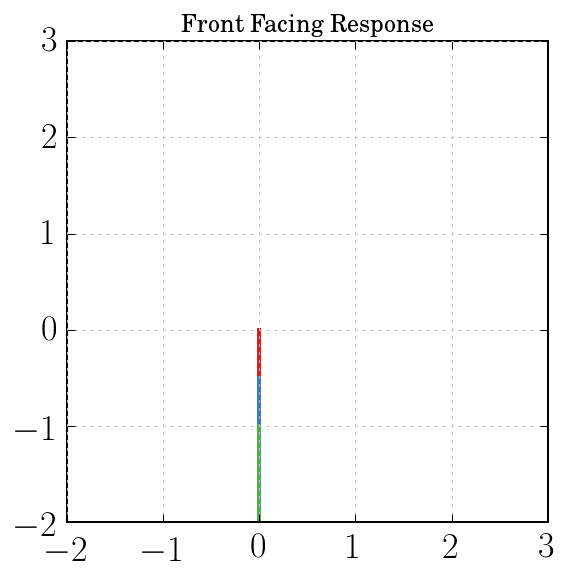

In [16]:
# mpl.rcParams['savefig.dpi'] = 72
# plt.figure(num=1, figsize=(14,4))
x_resp = resp[:,0]
y_resp = resp[:,1]
beta_resp = resp[:,2]
theta_resp = resp[:,3]
ax = plt.gca()
ax.set_aspect('equal')
# plt.subplot(131)
plt.plot(x_resp, y_resp)
pen1 =Length1*np.sin(beta_resp) + x_resp
pen2 = -Length1*np.cos(beta_resp) + y_resp

pen3 = (Length1*np.sin(beta_resp) + Length2*np.sin(theta_resp) + x_resp)
pen4 = (-Length1*np.cos(beta_resp) - Length2*np.cos(theta_resp) + y_resp)

plt.plot(pen1, pen2)
plt.plot(pen3, pen4)
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.title('Front Facing Response')

# plt.subplot(132)
# plt.plot(sys.times, resp[:,1])
# plt.title('Z Response')
# plt.gca().invert_yaxis()
# plt.subplot(133)
# plt.plot(sys.times, np.rad2deg(resp[:,2]))
# plt.title(r'$\beta$ Response')

In [15]:
constants = {m1: point1_mass,
             m2: point2_mass,
             M: cart_mass,
             g: 9.81,
             L1: Length1,
             L2: Length2}
op_point = {x:0, 
            x_dot:0, 
            y:0, 
            y_dot:0, 
            beta:0.0, 
            beta_dot:0, 
            theta:0.0, 
            theta_dot:0}

In [16]:
linearizer = kane.to_linearizer()
Maz, A_matrix, B_matrix = linearizer.linearize()
M_op = me.msubs(Maz, op_point)
A_op = me.msubs(A_matrix, op_point)
B_op = me.msubs(B_matrix, op_point)

In [17]:
perm_mat = linearizer.perm_mat
A_lin = perm_mat.T * M_op.LUsolve(A_op)
B_lin = perm_mat.T * M_op.LUsolve(B_op)

A_lin_constants = me.msubs(A_lin, constants)
B_lin_constants = me.msubs(B_lin, constants)
A_sol = A_lin_constants.subs(op_point).doit()
B_sol = B_lin_constants.subs(op_point).doit()

A_np = np.array(np.array(A_sol), np.float)
B_np = np.array(np.array(B_sol), np.float)

eigenvals, eigenvects = np.linalg.eig(A_np)

In [18]:
eigen = eigenvals[0:7:2]
nat_freq = eigen_abs = np.abs(eigen)
damp = np.abs(np.real(eigen)/eigen_abs)

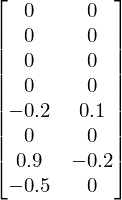

In [19]:
B_sol

## Multi-Input Shaping

In [20]:
s_0 = np.complex(0, 0)
s_1 = np.complex(-0.0694432415, 9.39132653)
s_2 = np.complex(-0.0255567585, 4.85478233)
s_3 = np.complex(0, 196.11613514)
s_0_star = np.conjugate(s_0)
s_1_star = np.conjugate(s_1)
s_2_star = np.conjugate(s_2)
s_3_star = np.conjugate(s_3)

g_0_0 = -0.2
g_0_1 = 0
g_0_2 = 0.9
g_0_3 = -0.5

g_1_0 = 0.1
g_1_1 = 0
g_1_2 = -0.2
g_1_3 = 0

In [21]:
a_full = np.array([0,0,0,0,0,0,0,0])
for i in range(10000):
    steps = np.linspace(0,1,10000)
    T = steps[i]
    P = np.array([[g_0_1, g_0_1*np.exp(-s_1*T), g_0_1*np.exp(-s_1*2*T), g_0_1*np.exp(-s_1*3*T),
             g_1_1, g_1_1*np.exp(-s_1*T), g_1_1*np.exp(-s_1*2*T), g_1_1*np.exp(-s_1*3*T)],
                  
            [g_0_1, g_0_1*np.exp(-s_1_star*T), g_0_1*np.exp(-s_1_star*2*T),g_0_1*np.exp(-s_1_star*3*T),
             g_1_1, g_1_1*np.exp(-s_1_star*T), g_1_1*np.exp(-s_1_star*2*T),g_1_1*np.exp(-s_1_star*3*T)],
                  
            [g_0_2, g_0_2*np.exp(-s_2*T), g_0_2*np.exp(-s_2*2*T),g_0_2*np.exp(-s_2*3*T),
             g_1_2, g_1_2*np.exp(-s_2*T), g_1_2*np.exp(-s_2*2*T),g_1_2*np.exp(-s_2*3*T)],
                  
            [g_0_2, g_0_2*np.exp(-s_2_star*T), g_0_2*np.exp(-s_2_star*2*T),g_0_2*np.exp(-s_2_star*3*T),
             g_1_2, g_1_2*np.exp(-s_2_star*T), g_1_2*np.exp(-s_2_star*2*T),g_1_2*np.exp(-s_2_star*3*T)],
                  
            [g_0_3, g_0_3*np.exp(-s_3*T), g_0_3*np.exp(-s_3*2*T),g_0_3*np.exp(-s_3*3*T),
             g_1_3, g_1_3*np.exp(-s_3*T), g_1_3*np.exp(-s_3*2*T),g_1_3*np.exp(-s_3*3*T)],
                  
            [g_0_3, g_0_3*np.exp(-s_3_star*T), g_0_3*np.exp(-s_3_star*2*T),g_0_3*np.exp(-s_3_star*3*T),
             g_1_3, g_1_3*np.exp(-s_3_star*T), g_1_3*np.exp(-s_3_star*2*T),g_1_3*np.exp(-s_3_star*3*T)],
           [1,1,1,1,0,0,0,0],[0,0,0,0,1,1,1,1]])
    P_inv = np.linalg.pinv(P)
    w = np.array([[0],[0],[0],[0],[0],[0],[1],[1]])
    a = np.dot(P_inv,w)
    a_row = np.real(a.reshape(1,8))
    a_full = np.vstack((a_full, a_row))
a_full = np.delete(a_full,0,0)
index=np.array([0])
for i in range(8):
    index = np.vstack((index,np.argwhere(a_full[:,i][50:] > 0)[0][0]))
index = np.delete(index,0,0)
index_arg = np.argmax(index)
time2 = round(steps[index[index_arg][0]],4)
time3 = round(time2 * 2,4)
time4 = round(time3 * 2,4)
impulse1_1 = round(a_full[:,0][index[index_arg][0]],4)
impulse1_2 = round(a_full[:,1][index[index_arg][0]],4)
impulse2_1 = round(a_full[:,2][index[index_arg][0]],4)
impulse2_2 = round(a_full[:,3][index[index_arg][0]],4)
impulse3_1 = round(a_full[:,4][index[index_arg][0]],4)
impulse3_2 = round(a_full[:,5][index[index_arg][0]],4)
impulse4_1 = round(a_full[:,6][index[index_arg][0]],4)
impulse4_2 = round(a_full[:,7][index[index_arg][0]],4)

In [36]:
a_full[:,1][312]

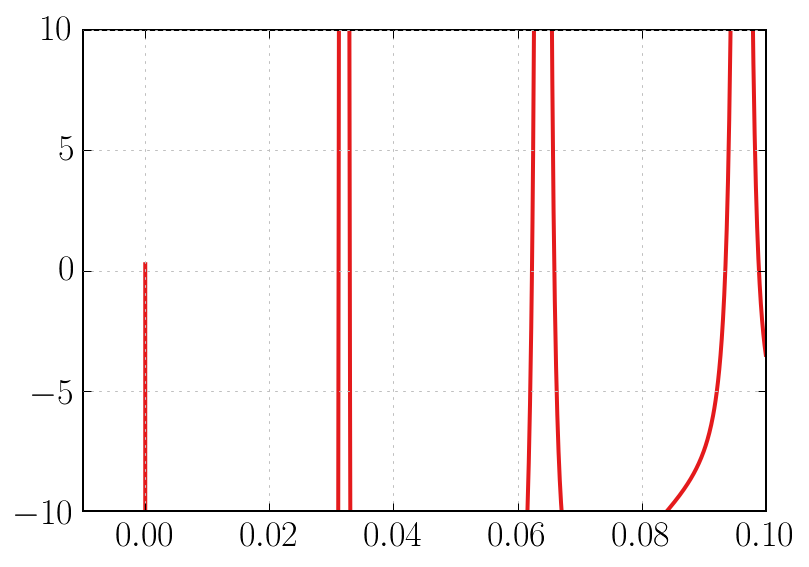

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
# plt.plot(steps,a_full[:,0])
# plt.plot(steps,a_full[:,1])
# plt.plot(steps,a_full[:,2])
# plt.plot(steps,a_full[:,3])
# plt.plot(steps,a_full[:,4])
# plt.plot(steps,a_full[:,5])
# plt.plot(steps,a_full[:,6])
plt.plot(steps,a_full[:,7])
# ax.annotate('local max', xy=(0.1, 1), xytext=(0.2, 1),
#             arrowprops=dict(facecolor='black', shrink=0.1),
#             )
plt.ylim(-10,10)
plt.xlim(-0.01,0.1);
plt.show()

In [96]:
df = pd.DataFrame({"Input 1":[impulse1_1,impulse1_2, impulse2_1,impulse2_2], 
                   "Input 2":[impulse3_1, impulse3_2,impulse4_1,impulse4_2],
                   "Times":[0,time2,time3,time4]})
itable.PrettyTable(df)

Input 1,Input 2,Times
0.1483,-306.4401,0.0
0.4231,304.7116,0.0197
-0.0572,306.6213,0.0394
0.4858,-303.8928,0.0788


Processing frame 0
Processing frame 30
Processing frame 60
Processing frame 90
Processing frame 120
Processing frame 150
Processing frame 180
Processing frame 210
Processing frame 240
Processing frame 270


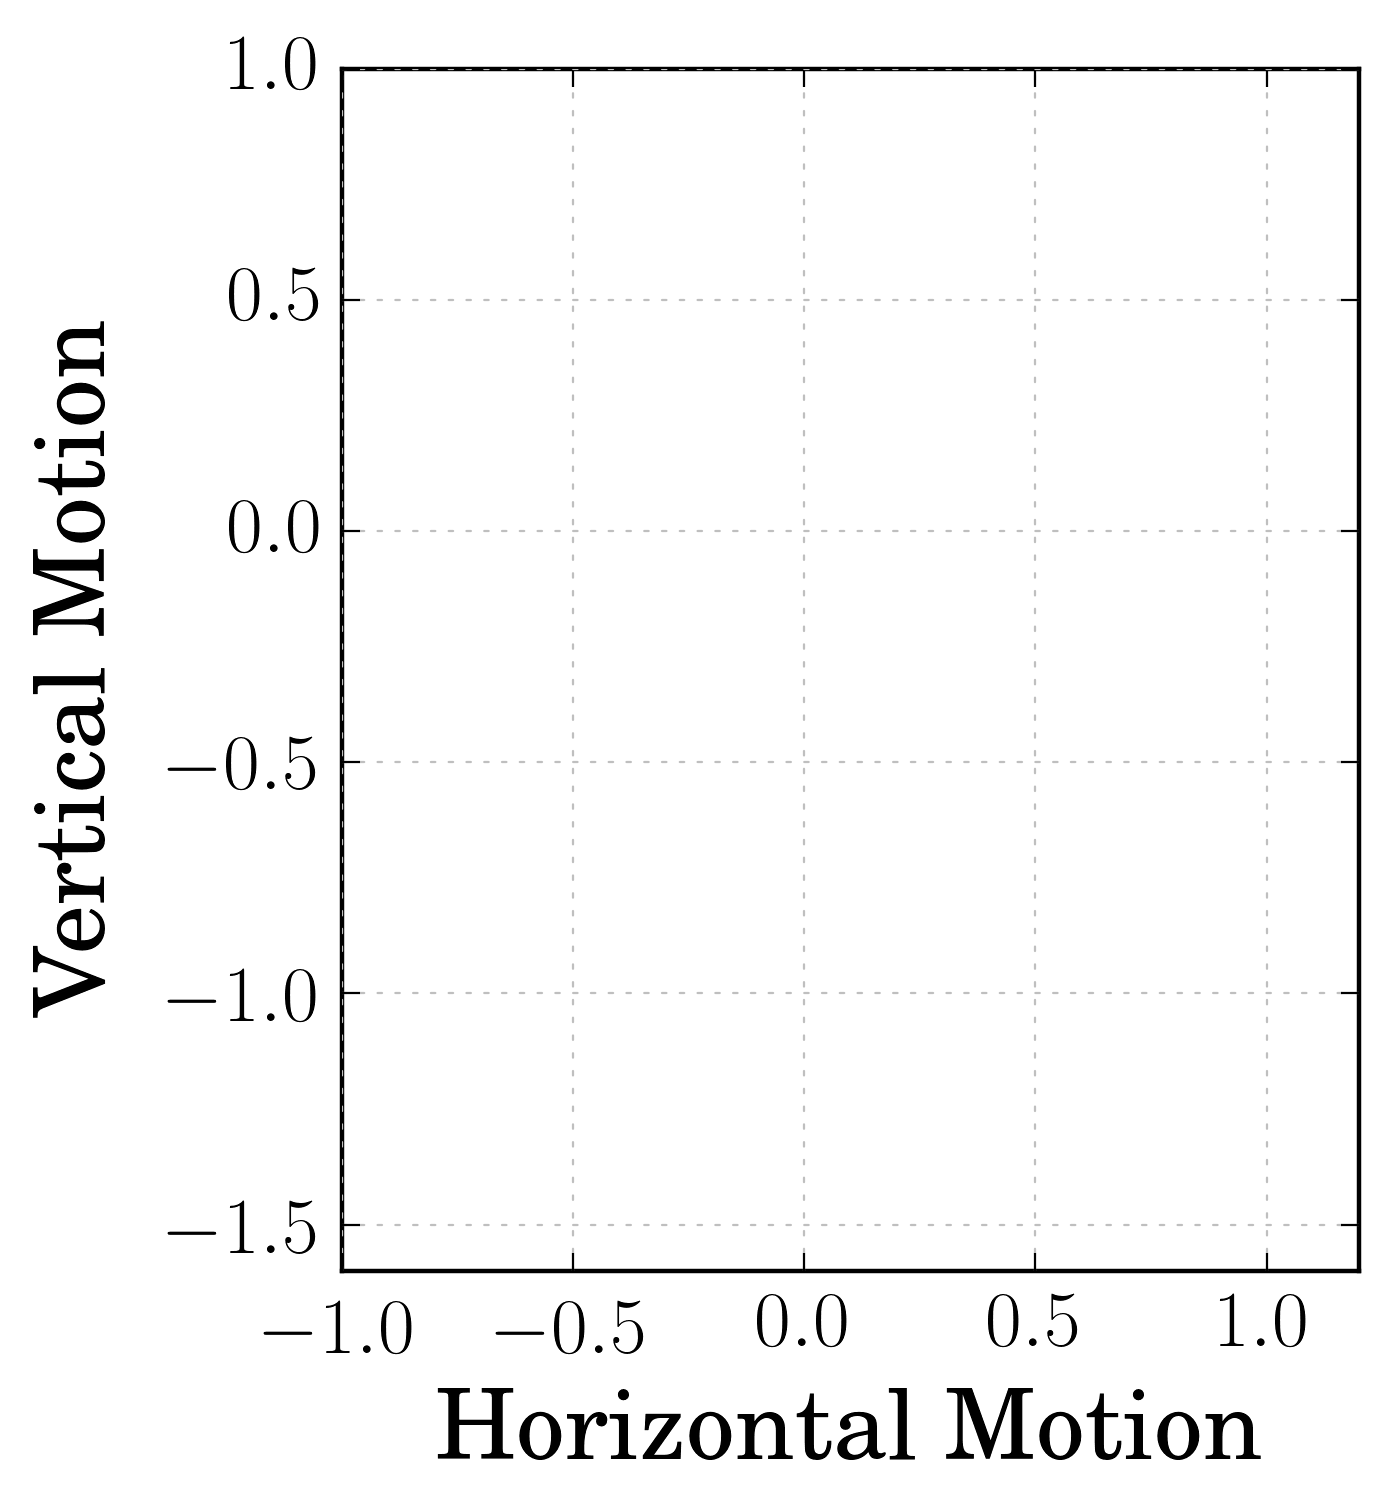

In [17]:
# What frame per second?
fps = 30

x_resp = resp[:,0]
y_resp = resp[:,1]
beta_resp = resp[:,2]
theta_resp = resp[:,3]
# For the cables and top of rectangle
pen1_x =Length1*np.sin(beta_resp) + x_resp
pen1_y = -Length1*np.cos(beta_resp) + y_resp

pen2_x = (Length1*np.sin(beta_resp) + Length2*np.sin(theta_resp) + x_resp)
pen2_y = (-Length1*np.cos(beta_resp) - Length2*np.cos(theta_resp) + y_resp)

# pen3_x = (Length1*np.sin(beta_resp) + Length2*np.sin(theta_resp) + Length3*np.sin(gamma_resp) + x_resp)
# pen3_y = (-Length1*np.cos(beta_resp) - Length2*np.cos(theta_resp) - Length3*np.cos(gamma_resp) + y_resp)

import matplotlib.animation as animation
import matplotlib.pyplot as plt
# Change some plot properties to make the video work and look better
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot(111, aspect='equal')
plt.ylim(-1.6,1.0)
plt.xlim(-x_resp[0]-1, x_resp[0]+1.2)
plt.xlabel('Horizontal Motion', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Motion', fontsize=22, weight='bold', labelpad=10)
# plt.axes().set_aspect('equal')

# leftcable, = plt.plot([],[], linewidth=0.5, linestyle = '-',
#                       label='leftcable', color='b')
# rightcable, = plt.plot([],[], linewidth=0.5, linestyle = '-',
#                        label='rightcable', color='b')
# barLine, = plt.plot([],[], linewidth=2, linestyle = '-', label='Bar')
patch = patches.Rectangle((0, 0), 0, 0, angle=0)
first_rod, = plt.plot([],[], linewidth=1, linestyle = '-',
                      label='leftcable', color='b')
second_rod, = plt.plot([],[], linewidth=1, linestyle = '-',
                      label='leftcable', color='b')
# third_rod, = plt.plot([],[], linewidth=1, linestyle = '-',
#                       label='leftcable', color='b')
dotP1, = plt.plot([],[], 'ro', label='Center of Gravity')
dotP2, = plt.plot([],[], 'ro', label='Center of Gravity')
# dotP3, = plt.plot([],[], 'ro', label='Center of Gravity')
# rod,    = plt.plot([],[], linewidth=6, linestyle = '-', label='rod',
#                    color='r')

def init():
    """ Initialize the lines in the plot """
    first_rod.set_data([], [])
    second_rod.set_data([], [])
#     third_rod.set_data([], [])
    dotP1.set_data([],[])
    dotP2.set_data([],[])
#     dotP3.set_data([],[])
    ax.add_patch(patch)
#     rod.set_data([],[])

    return first_rod, second_rod, dotP1, dotP2, patch,

def animate_un(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))

    first_rod.set_data([x_resp[i], pen1_x[i]], [y_resp[i], pen1_y[i]])
    second_rod.set_data([pen1_x[i], pen2_x[i]], [pen1_y[i], pen2_y[i]])
#     third_rod.set_data([pen2_x[i], pen3_x[i]], [pen2_y[i], pen3_y[i]])
    dotP1.set_data([[pen1_x[i]],[pen1_y[i]]])
    dotP2.set_data([[pen2_x[i]],[pen2_y[i]]])
#     dotP3.set_data([[pen3_x[i]],[pen3_y[i]]])
    patch.set_width(0.2)
    patch.set_height(0.1)
    patch.set_xy([x_resp[i]-0.1, y_resp[i]-0.05])
    patch._angle = np.rad2deg(0)
#     plt.xlim(x_resp[i]-1, x_resp[i]+1)

    return first_rod, second_rod, dotP1, dotP2, patch,

ani_un = animation.FuncAnimation(fig, animate_un, interval = fps,
        frames = runtime*fps, blit = True, init_func = init)

ani_un.save('/Users/forrest/Desktop/{}.mp4'.format('triple_Pen'), bitrate = 2500, fps = fps)